In [325]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from datetime import timezone
import seaborn as sns
from numba import njit
sys.path.append('/home/manu/TFG_repo/scripts')

In [327]:
from config import data_dir
from analysis_routines import *
from ploting_routines import *
from processing_routines import *

plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [249]:
data_path = data_dir / 'raw' / 'thermistor_chain' / 'AGL_Octubre_2020' / 'SBE56' / 'Data_May_Oct_2020_SBE56.mat'
data = loadmat(data_path)

In [251]:
del data['__header__']
del data['__version__']
del data['__globals__']
del data['cmap']
del data['cc']

In [252]:
min_length = min([len(data[i]) for i in data])
n_depths = len(data)
min_length = min([len(data[i]) for i in data])

date = np.zeros((min_length, n_depths))
temp = np.zeros_like(date)
depths = np.array([1, 8, 23, 28, 33, 38, 43, 53, 63, 78, 93, 108, 126, 151, 176])
for i in data:
    depth_str = i.split('_')[1]
    if 'm' in depth_str:
        depth_str = depth_str[0]
    depth = int(depth_str)
    idx = np.argmax(depths==depth)
    
    temp_date_i = data[i].T
    date[:, idx] = temp_date_i[0][:min_length]
    temp[:, idx] = temp_date_i[1][:min_length]
    
real_depths = depths
real_depths[2:] += 9

In [307]:
print(real_depths)
print(np.mean(up_37_pres), np.mean(low_37_pres))

[  1   8  32  37  42  47  52  62  72  87 102 117 135 160 185]
60.494997944122304 220.29716782184747


In [253]:
if (date[:, 1:]==date[:, :-1]).all():
    date = datenum_to_epoch(date[:, 0])

In [254]:
date[122:] += 1

In [255]:
date_datetime = np.array([datetime.utcfromtimestamp(i) for i in date])

IndexError: index 0 is out of bounds for axis 0 with size 0

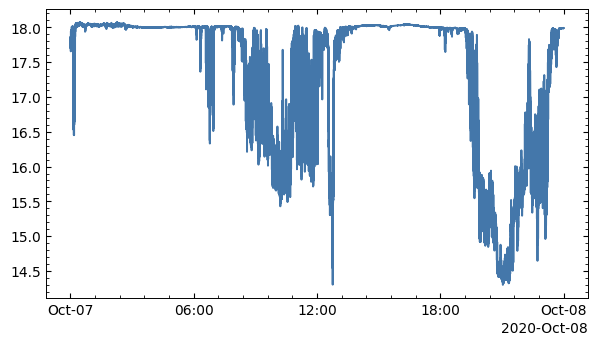

In [245]:
plot_thermistor_temperature(temp, depths, date_datetime, 4, lims=[datetime(2020, 10, 7), datetime(2020,  10, 8)])

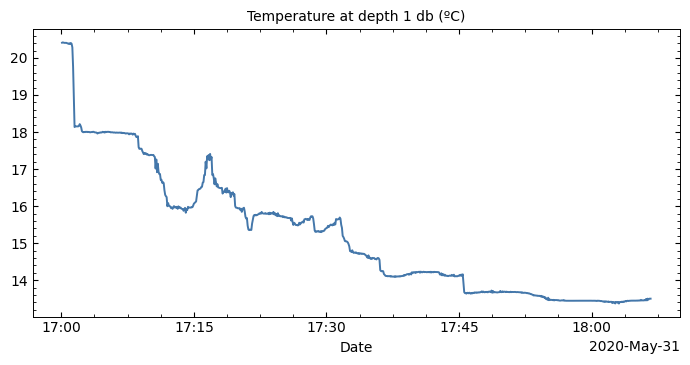

In [242]:
plot_thermistor_temperature(temp, depths, date_datetime, 4, lims=[0, 800])

In [256]:
date_start = datetime(2020, 5, 31, 18)
idx_start = date_to_idx(date_datetime, date_start)
date_crop = datetime(2020, 10, 7, 6)
idx_crop = date_to_idx(date_datetime, date_crop) + 1

In [257]:
print(f'crop series at {idx_crop}')

crop series at 2221200


In [258]:
temp = temp[idx_start:idx_crop]
date = date[idx_start:idx_crop]
date_datetime = date_datetime[idx_start:idx_crop]

2020-10-07 06:00:00


In [273]:
up_37 = loadmat(data_dir / 'raw' / 'thermistor_chain' / 'AGL_Octubre_2020' / 'SBE37_5674' / 'SBE37567420201010.mat')
up_37_epoch = datenum_to_epoch(np.squeeze(up_37['dates']))[6:]
up_37_datetime = np.array([datetime.utcfromtimestamp(i) for i in up_37_epoch])
up_37_pres = np.squeeze(up_37['pre'])[6:]
up_37_temp = np.squeeze(up_37['tem'])[6:]
# we take values starting from 6: to not take lowering of thermistor period and
# to start at 18:00 like SBE56

In [274]:
low_37_path = data_dir / 'raw' / 'thermistor_chain' / 'AGL_Octubre_2020' / 'SBE37_3465' / 'SBE37SM-RS232_3465_2020_10_10.asc'
low_37 = pd.read_csv(low_37_path, names=['temp', 'cond', 'pres', 'date', 'time'], skiprows=58)
low_37['datetime'] = low_37['date'] + low_37['time']
low_37['datetime'] = low_37['datetime'].apply(lambda x: datetime.strptime(x[1:], '%d %b %Y %H:%M:%S'))
low_37 = low_37.drop(['date', 'time'], axis=1)
low_37_datetime = low_37['datetime'].to_numpy(dtype=datetime)[12:]
low_37_pres = low_37['pres'].to_numpy()[12:]
low_37_temp = low_37['temp'].to_numpy()[12:]

In [279]:
print('Alguna medida tiene un intervalo diferente a 10 mins en low_37?: {}'.format((low_37_datetime[1:] - low_37_datetime[:-1] != timedelta(minutes=5)).any()))

Alguna medida tiene un intervalo diferente a 10 mins en low_37?: True


In [281]:
print('Alguna medida tiene un intervalo diferente a 5 mins en up_37?: {}'.format((up_37_datetime[1:]-up_37_datetime[:-1] != timedelta(minutes=10)).any()))

Alguna medida tiene un intervalo diferente a 5 mins en up_37?: False


In [282]:
low_37_datetime = remove_seconds(low_37_datetime)

In [267]:
@np.vectorize
def remove_seconds(date):
    if date.second == 1:
        return date - timedelta(seconds=1)
    else:
        return date

In [284]:
print('Alguna medida tiene un intervalo diferente a 5 mins en low_37?: {}'.format((low_37_datetime[1:] - low_37_datetime[:-1] != timedelta(minutes=5)).any()))

Alguna medida tiene un intervalo diferente a 5 mins en low_37?: False


In [301]:
last_up = np.where(up_37_datetime == date_crop)[0][0]
last_low = np.where(low_37_datetime == date_crop)[0][0]
#last_up_date_loc = np.where(date_datetime == up_37_datetime[last_up_37_loc])[0]
#last_low_date_loc = np.where(date_datetime == low_37_datetime[last_low_37_loc])[0]

In [297]:
print()

[18504]
[37008]


In [310]:
# array de temperaturas
masked_temp = np.ma.masked_all_like(np.zeros((len(date_datetime), 17)))
masked_temp[:, 0:7] = temp[:, :7]
masked_temp[::120, 7] = up_37_temp[:last_up + 1]
masked_temp[::60, -1] = low_37_temp[:last_low + 1]
masked_temp[:, 8:-1] = temp[:, 7:]

In [313]:
# array de presiones
masked_pres = np.ma.masked_all_like(np.zeros((len(date_datetime), 17)))
masked_pres[:, 0:7] = depths[None, :7]
masked_pres[::120, 7] = up_37_pres[:last_up + 1]
masked_pres[::60, -1] = low_37_pres[:last_low + 1]
masked_pres[:, 8:-1] = depths[None, 7:]

In [321]:
print('Cada 120 elementos (10 min) de masked temp, hay 16 medidas:', (masked_temp[::120].count(axis=1)==17).all())
print('Cada 60 elementos (5 min) de masked temp, hay 15 medidas o más:', (masked_temp[::60].count(axis=1) >= 16).all())

Cada 120 elementos (10 min) de masked temp, hay 16 medidas: True
Cada 60 elementos (5 min) de masked temp, hay 15 medidas o más: True


In [355]:
temp, pres, date = load_time_series('unprocessed/AGL_20200531_chain.nc')

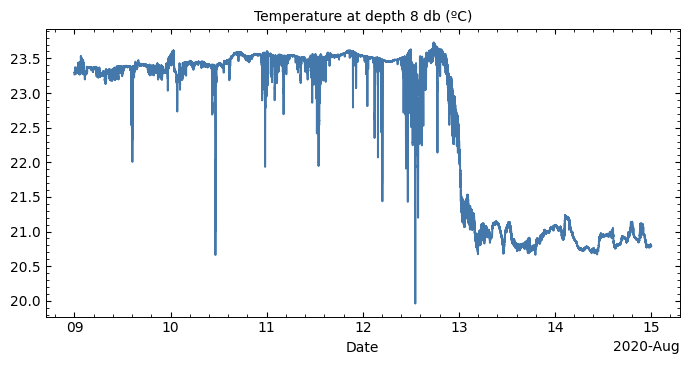

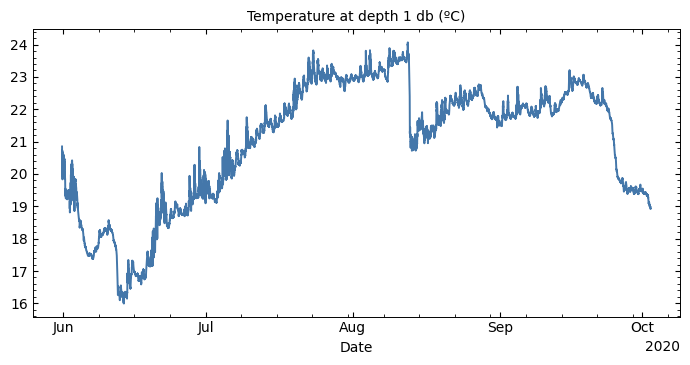

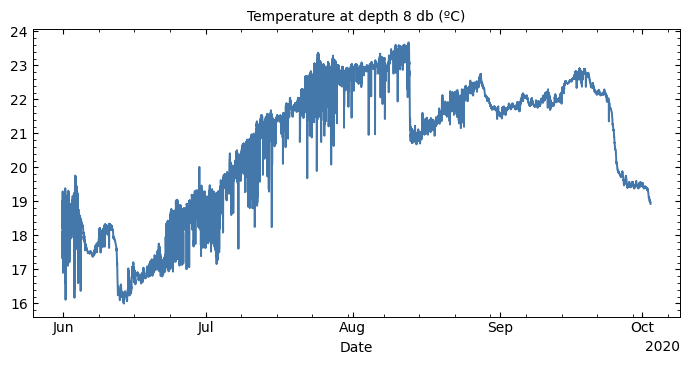

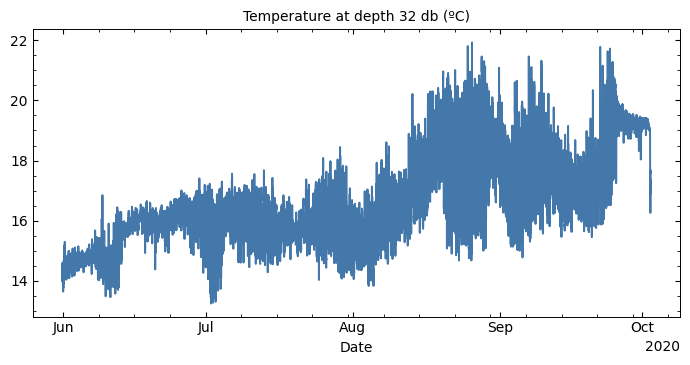

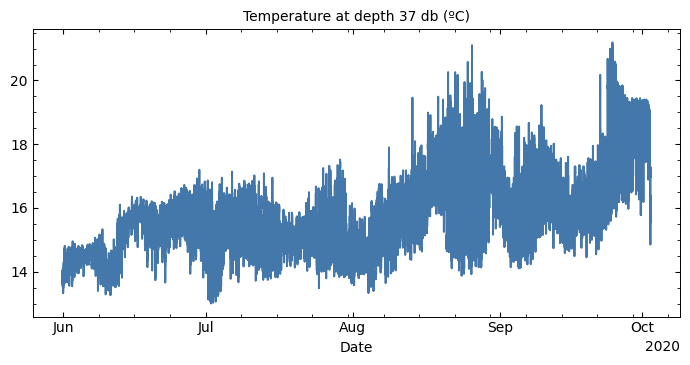

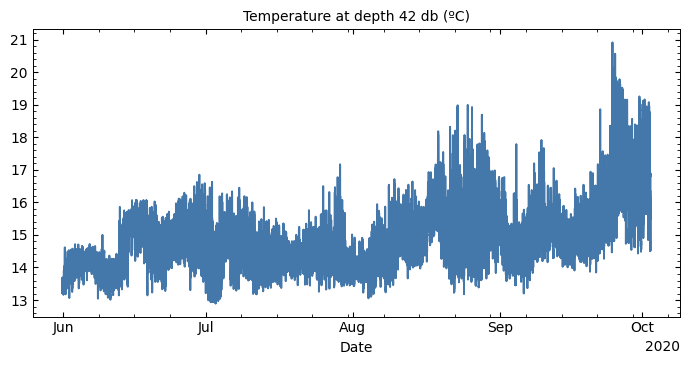

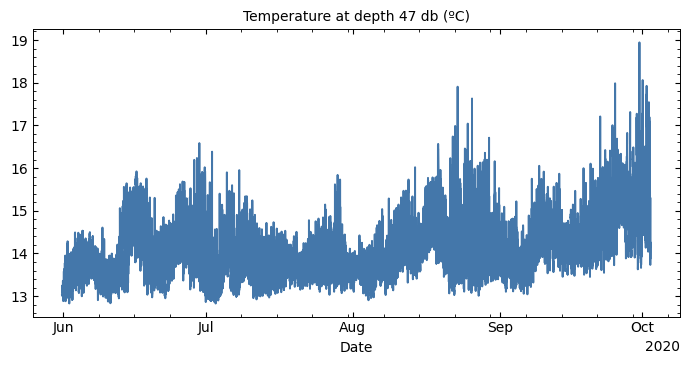

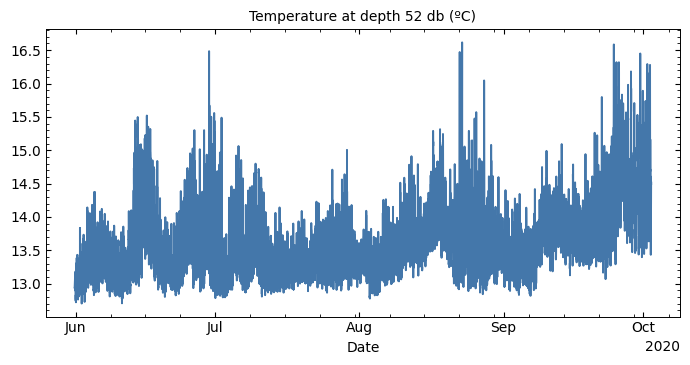

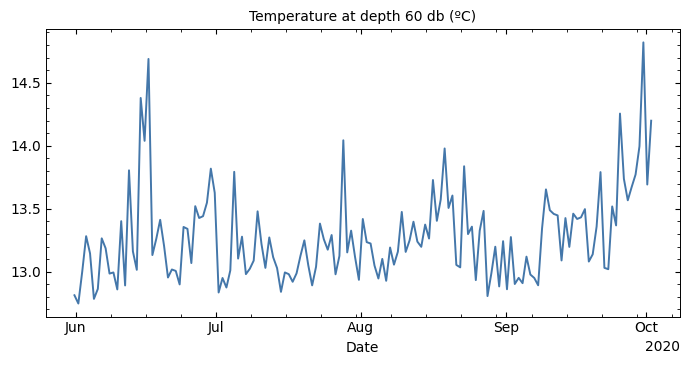

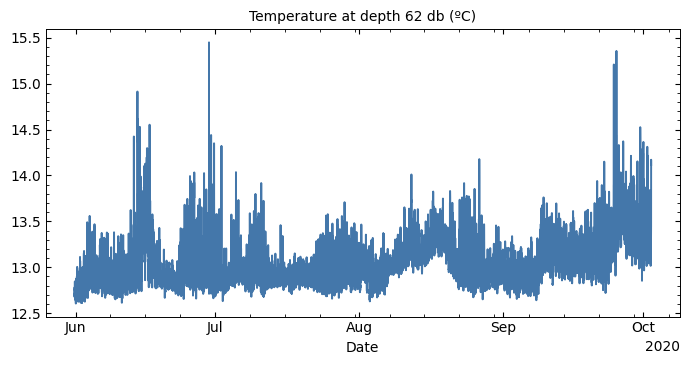

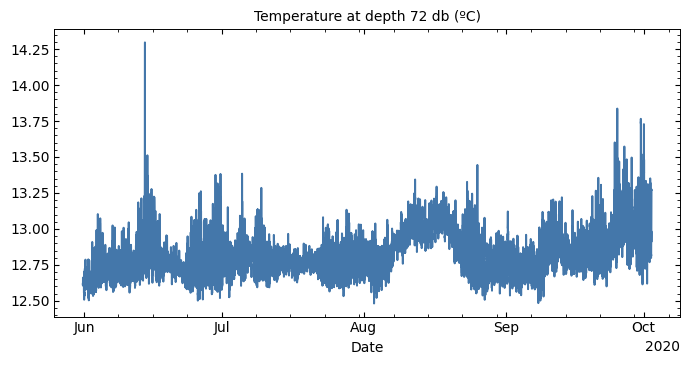

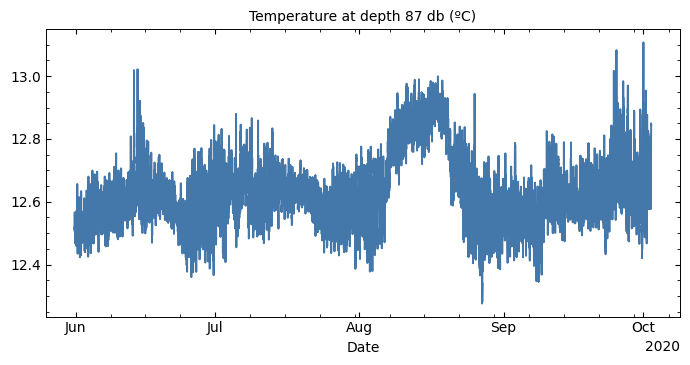

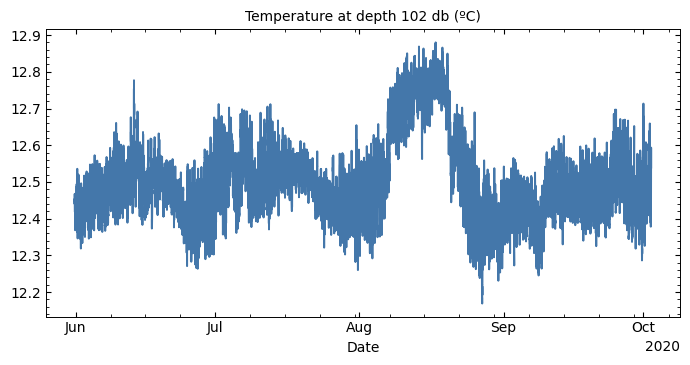

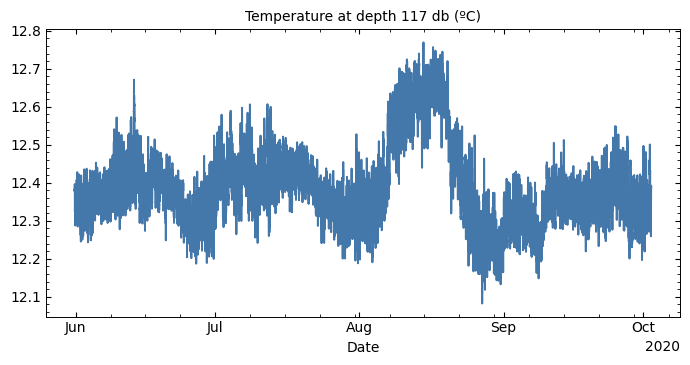

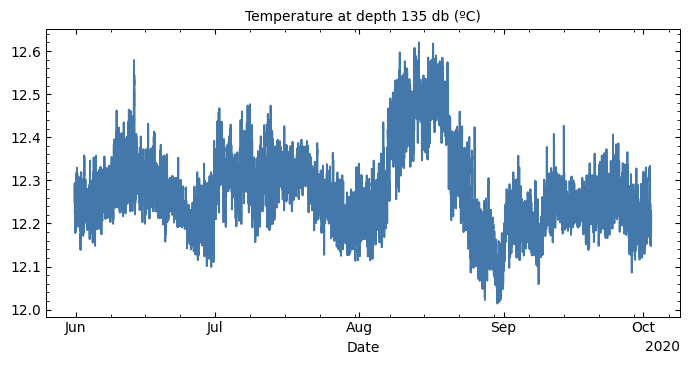

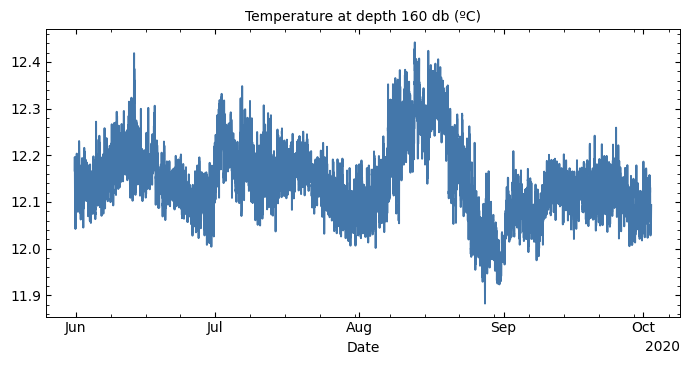

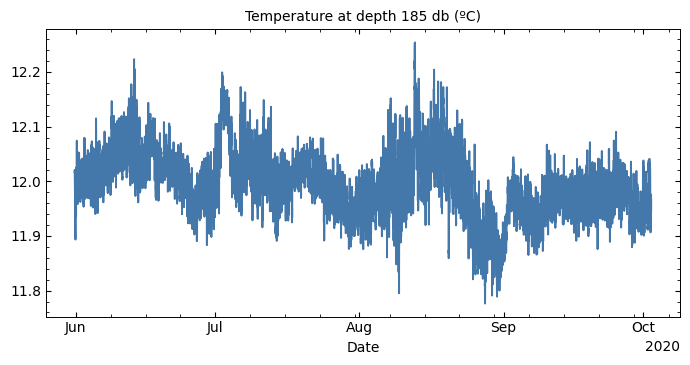

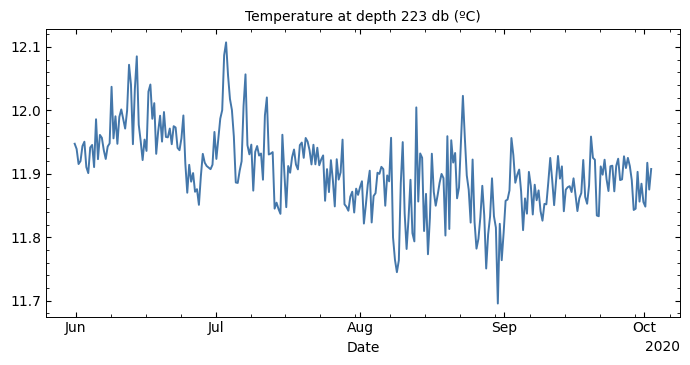

In [356]:
for i in range(temp.shape[1]):
    plot_thermistor_temperature(temp, pres, date, i, interval=timedelta(minutes=10))

range(0, 17)


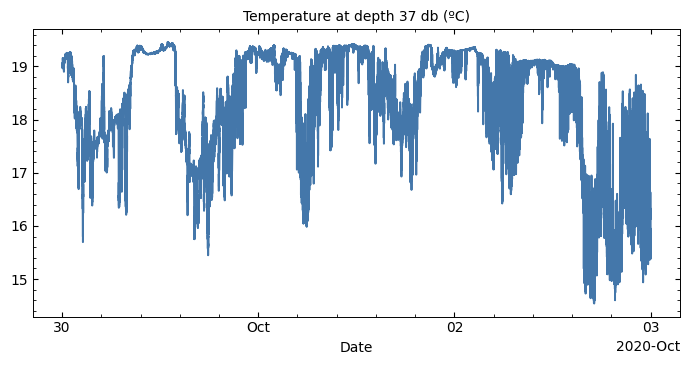

In [350]:
plot_thermistor_temperature(temp, pres, date, 3, lims=[datetime(2020, 9, 30), datetime(2020, 10, 3)])

In [346]:
date_1 = datetime(2020, 10, 3)

Help on function plot_profile_fit in module ploting_routines:

plot_profile_fit(df, temp, depth, loc)
    Plot measured vertical profile and fit for measure at loc

None
